In [38]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


%matplotlib inline

In [2]:
def region_mask(image):
    ysize = image.shape[0]
    xsize = image.shape[1]
    region_select = np.copy(image)

    left_bottom = [0, ysize]
    right_bottom = [xsize, ysize]
    apex = [xsize / 2, ysize / 3]

    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    region_select[~region_thresholds] = False
    return region_select


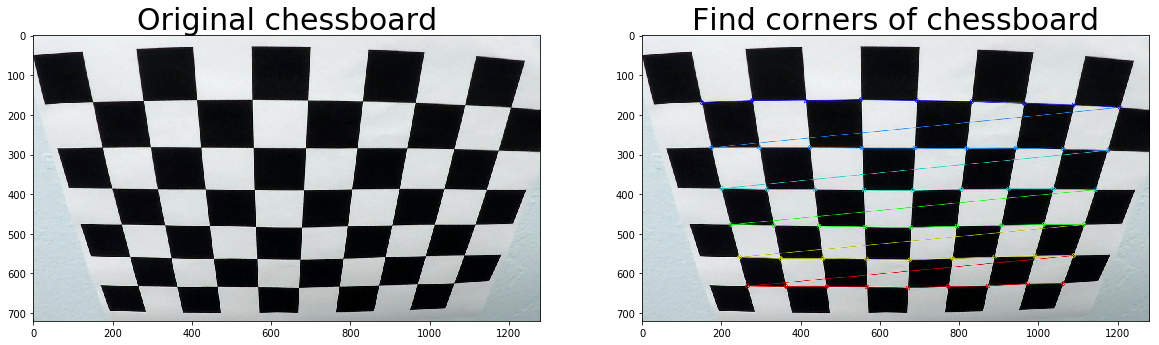

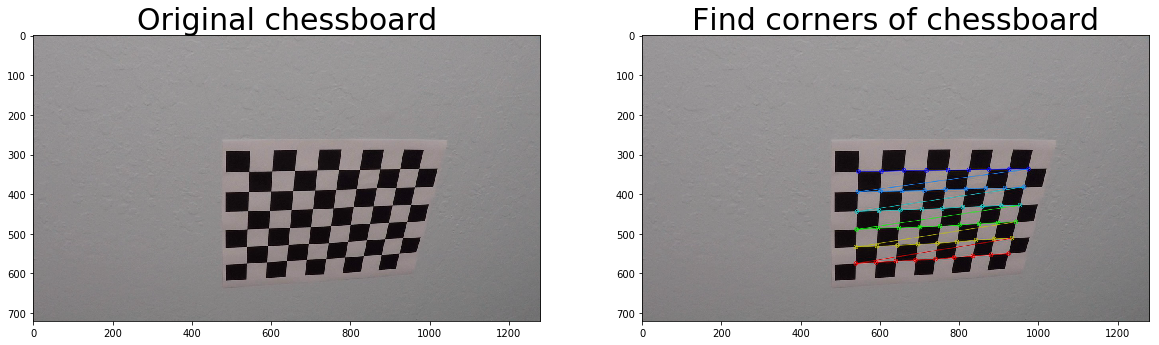

In [3]:
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')
images.sort()
img_size = (0, 0)

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = fname.replace('camera_cal', 'output_images').replace('calibration', 'corners_found')
        cv2.imwrite(write_name, img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.imread('camera_cal/calibration2.jpg'))
ax1.set_title('Original chessboard', fontsize=30)
ax2.imshow(cv2.imread('output_images/corners_found2.jpg'))
ax2.set_title('Find corners of chessboard', fontsize=30)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.imread('camera_cal/calibration10.jpg'))
ax1.set_title('Original chessboard', fontsize=30)
ax2.imshow(cv2.imread('output_images/corners_found10.jpg'))
ax2.set_title('Find corners of chessboard', fontsize=30)


In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )


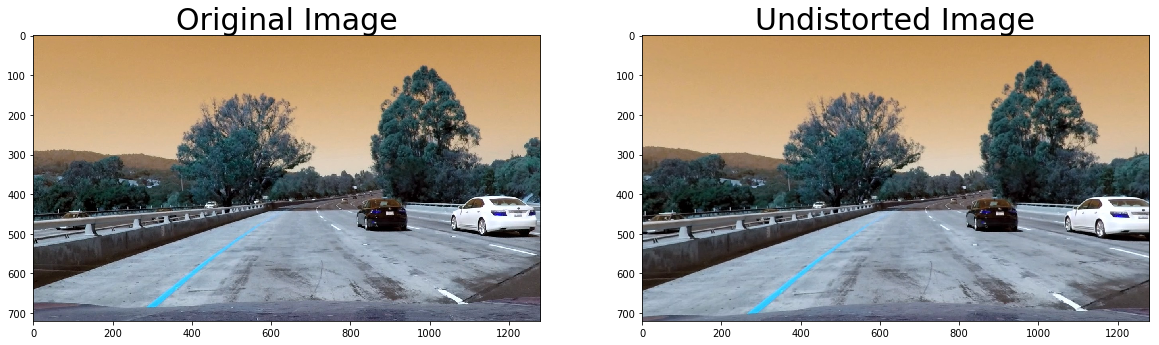

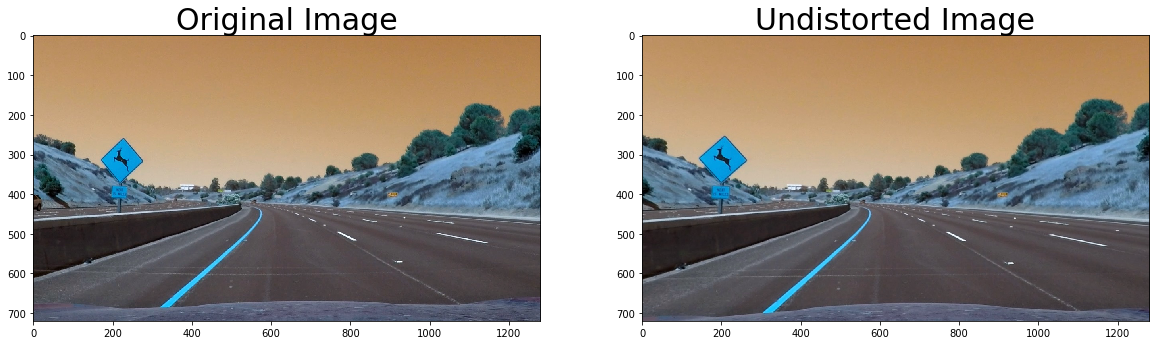

In [6]:

# Test undistortion on an image
def TestCalibration(inputfile, outputfile):
    img = cv2.imread(inputfile)
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(outputfile,dst)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

for i in range(1, 3):
    TestCalibration('test_images/test%d.jpg'%(i), 'output_images/undistorted_test%d.jpg'%(i))


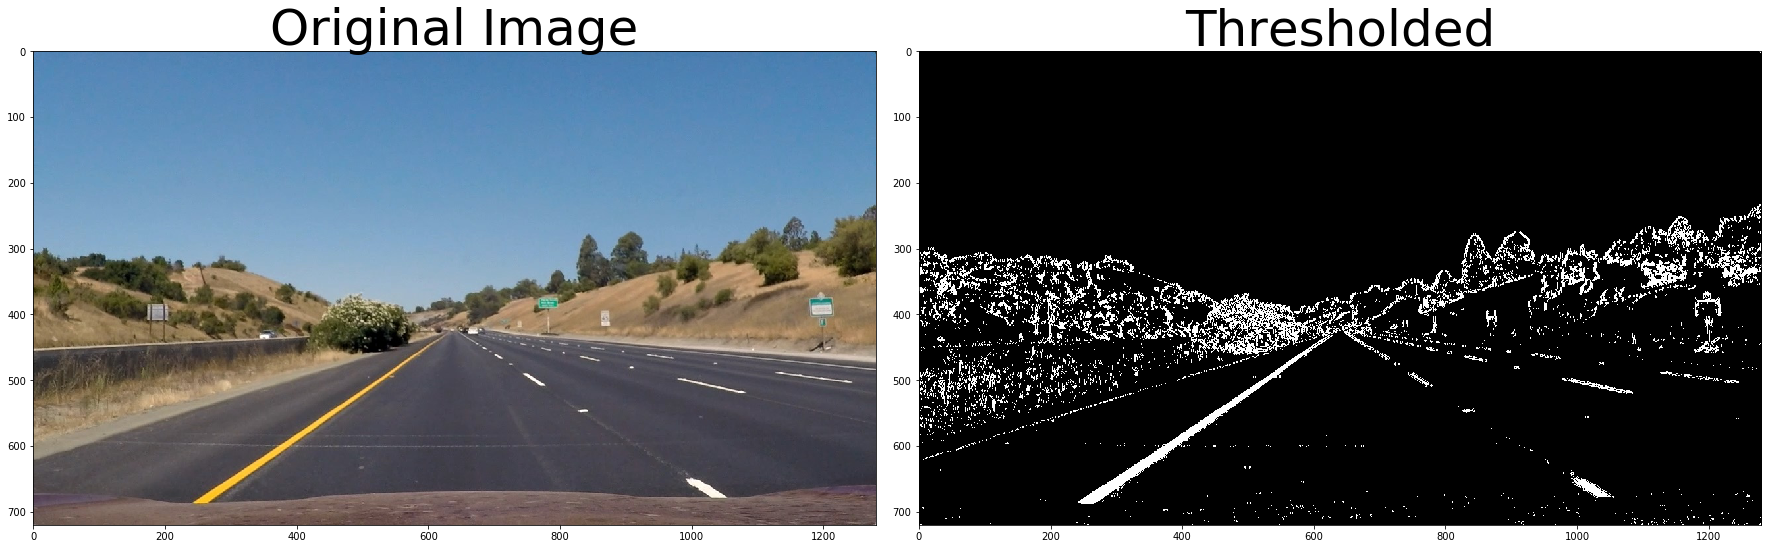

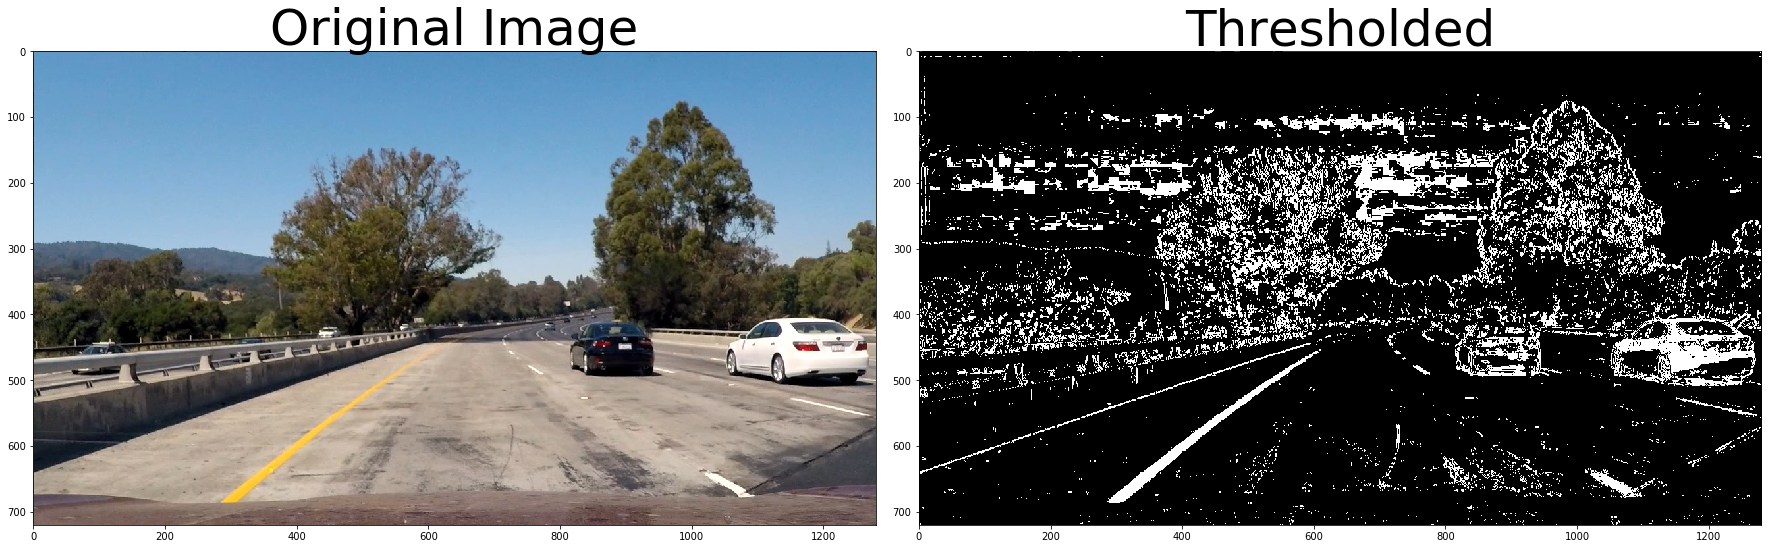

In [63]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


def s_threshold(s_channel, s_thres=(0, 255)):
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thres[0]) & (s_channel <= s_thres[1])] = 1
    return s_binary

def hls_select(img):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    ksize = 3
    gradx = abs_sobel_thresh(l_channel, orient='x', thresh=(20, 100))
    mag_binary = mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(l_channel, sobel_kernel=ksize, thresh=(0.7, 1.3))
    s_binary = s_threshold(s_channel, s_thres=(130, 255))
    combined = np.zeros_like(dir_binary)

    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1) | (s_binary == 1))] = 1
    return combined

def TestHlsImage(inputfile):
    image = mpimg.imread(inputfile) 

    hls_binary = hls_select(image)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(hls_binary, cmap='gray')
    ax2.set_title('Thresholded', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
TestHlsImage('test_images/straight_lines1.jpg')
TestHlsImage('test_images/test1.jpg')



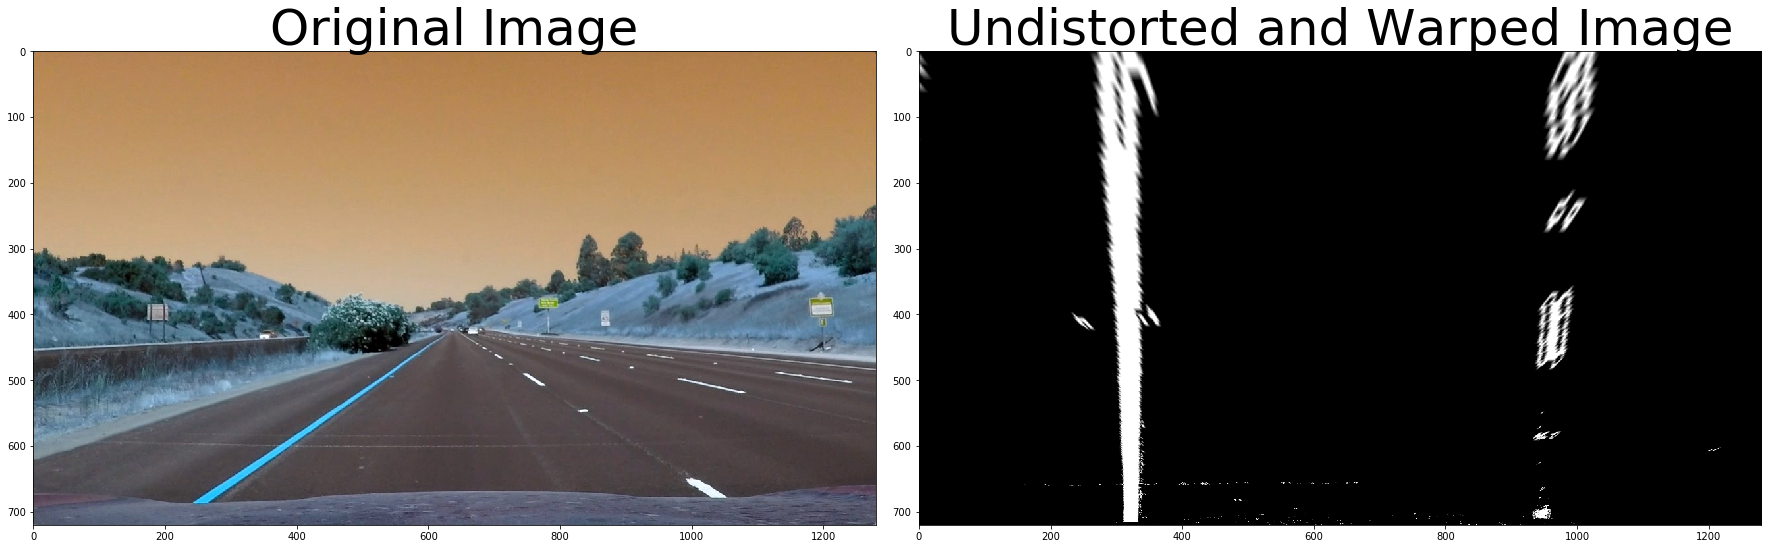

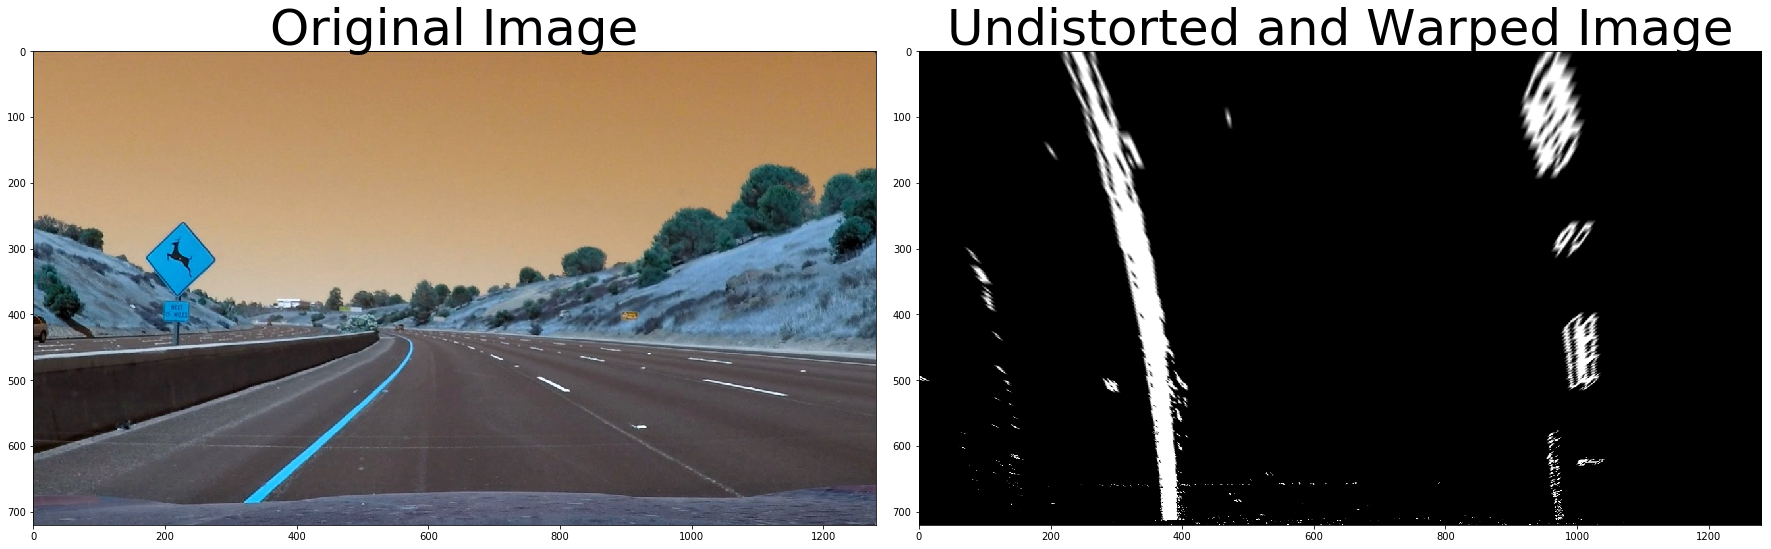

In [8]:

def corners_unwarp(img, nx, ny, mtx, dist):

    
    img = cv2.undistort(img, mtx, dist, None, mtx) 
    img = hls_select(img)    
    img = region_mask(img)

    src = np.float32(
         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
         [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def TestUnwarp(inputfile):
    # Read in an image
    img = cv2.imread(inputfile)
    top_down, _, _ = corners_unwarp(img, nx, ny, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(top_down, cmap='gray')
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

TestUnwarp('test_images/straight_lines1.jpg')
TestUnwarp('test_images/test2.jpg')


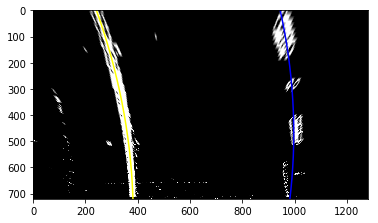

In [55]:

def plot_line_without_previous_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(int(binary_warped.shape[1]/2))
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

def plot_line_with_previous_fit(binary_warped, left_fit, right_fit, ploty):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

    
    
def TestPlotLine(inputfile):
    img = mpimg.imread(inputfile)
    binary_warped, M, Minv = corners_unwarp(img, nx, ny, mtx, dist)
    out_img, _, _, left_fitx, right_fitx, ploty = plot_line_without_previous_fit(binary_warped)
    plt.imshow(binary_warped, cmap='gray')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='blue')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
TestPlotLine('test_images/test2.jpg')


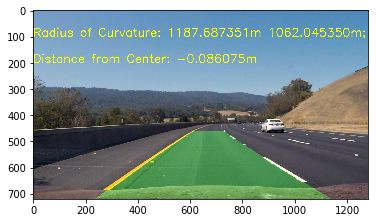

In [56]:
def get_curve(leftx, rightx, ploty):
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_x_int = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]
    right_x_int = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]
    vehicles_center = (img_size[0]/2 - ((right_x_int+left_x_int)/2)) * xm_per_pix

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad, vehicles_center

def process_single_image(img):
    warped, M, Minv = corners_unwarp(img, nx, ny, mtx, dist)
    _, _, _, left_fitx, right_fitx, ploty = plot_line_without_previous_fit(warped)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result, left_fitx, right_fitx, ploty

def TestGetCurve(inputfile):
    img = mpimg.imread(inputfile)
    img, left_fitx, right_fitx, ploty = process_single_image(img)
    left_curverad, right_curverad, vehicles_center = get_curve(left_fitx, right_fitx, ploty)
    
    cv2.putText(img, "Radius of Curvature: %fm %fm;" %(left_curverad, right_curverad),(0,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(img, "Distance from Center: %fm" %(vehicles_center),(0,200), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,0),2,cv2.LINE_AA)
    plt.imshow(img)
    

TestGetCurve('test_images/test3.jpg')
#TestGetCurve('test_images/test2.jpg')


In [67]:
previous_left_fit = None
previous_right_fit = None
previous_ploty = None

def process_image(img):
    global previous_left_fit
    global previous_right_fit
    global previous_ploty
    warped, M, Minv = corners_unwarp(img, nx, ny, mtx, dist)
    if previous_left_fit is None:
        _, left_fit, right_fit, left_fitx, right_fitx, ploty = plot_line_without_previous_fit(warped)
    else:
        _, left_fit, right_fit, left_fitx, right_fitx, ploty = plot_line_with_previous_fit(warped, previous_left_fit, previous_right_fit, previous_ploty)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    left_curverad, right_curverad, vehicles_center = get_curve(left_fitx, right_fitx, ploty)
    
    cv2.putText(result, "Radius of Curvature: %fm %fm;" %(left_curverad, right_curverad),(0,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(result, "Distance from Center: %fm" %(vehicles_center),(0,200), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,0),2,cv2.LINE_AA)
    
    previous_left_fit = left_fit
    previous_right_fit = right_fit
    previous_ploty = ploty
    return result
    
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.subclip(0.0, 2.0)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:07<00:00,  5.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 3min 47s, sys: 45.5 s, total: 4min 33s
Wall time: 4min 8s
